<a href="https://colab.research.google.com/github/joaopcnogueira/colab-notebooks/blob/main/Customer_Lifetime_Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install plotnine

In [27]:
import numpy as np
import pandas as pd
from plotnine import *

# 1.0 Data Preparation

In [3]:
cdnow_raw_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/CDNOW_master.txt", sep   = "\s+",names = ["customer_id", "date", "quantity", "price"])
cdnow_raw_df.head()

,customer_id,date,quantity,price
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


In [4]:
cdnow_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  int64  
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


In [7]:
cdnow_df = cdnow_raw_df \
  .assign(date = lambda x: x['date'].astype(str)) \
  .assign(date = lambda x: pd.to_datetime(x['date']))

In [8]:
cdnow_df.head()

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76


In [9]:
cdnow_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  69659 non-null  int64         
 1   date         69659 non-null  datetime64[ns]
 2   quantity     69659 non-null  int64         
 3   price        69659 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.1 MB


# 2.0 Cohort Analysis

Only the customers that have joined at the specific business day

In [14]:
# Get Range of Initial Purchases ----
cdnow_first_purchase_df = cdnow_df \
    .sort_values(['customer_id', 'date']) \
    .groupby('customer_id') \
    .first()

cdnow_first_purchase_df

,date,quantity,price
customer_id,,,
1,1997-01-01,1,11.77
2,1997-01-12,1,12.00
3,1997-01-02,2,20.76
4,1997-01-01,2,29.33
5,1997-01-01,2,29.33
...,...,...,...
23566,1997-03-25,2,36.00
23567,1997-03-25,1,20.97
23568,1997-03-25,1,22.97


In [15]:
cdnow_first_purchase_df.agg({'date': ['min', 'max']})

,date
min,1997-01-01
max,1997-03-25


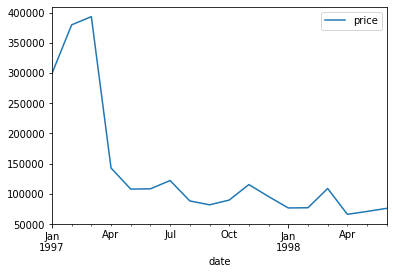

In [21]:
# Visualize: All purchases within cohort
cdnow_df \
  .reset_index() \
  .set_index('date') \
  .filter(['price']) \
  .resample(rule="MS") \
  .sum() \
  .plot()

In [22]:
# Visualize: Individual Customer Purchases
ids = cdnow_df['customer_id'].unique()
ids_selected = ids[0:10]

In [25]:
cdnow_cust_id_subset_df = cdnow_df \
    [cdnow_df['customer_id'].isin(ids_selected)] \
    .groupby(['customer_id', 'date']) \
    .sum() \
    .reset_index()

/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  "group aesthetic?", PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  "group aesthetic?", PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
  "group aesthetic?", PlotnineWarning)


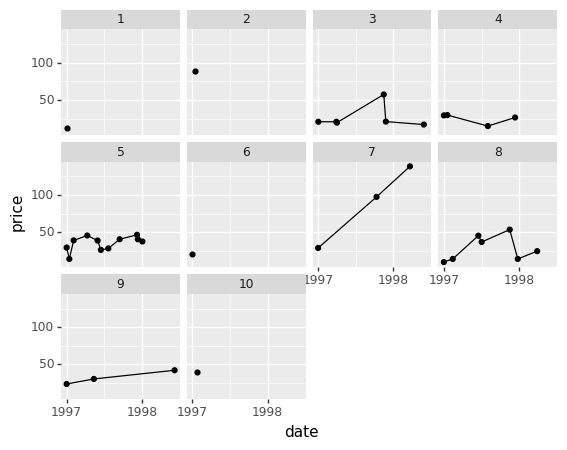

<ggplot: (8789750293941)>

In [34]:
ggplot(aes(x='date', y='price', group='customer_id'), data=cdnow_cust_id_subset_df) \
  + geom_line() \
  + geom_point() \
  + facet_wrap('customer_id') \
  + scale_x_date(
      date_breaks = "1 year",
      date_labels = "%Y"
  )

# 3.0 Machine Learning

Frame the problem:

- What will the customers spend in the next 90-days? (Regression)
- What is the probability of a customer to make a purchase in next 90-days? (Classification)

## 3.1 Time Splitting (Stage 1) 

In [35]:
n_days   = 90
max_date = cdnow_df['date'].max() 
cutoff   = max_date - pd.to_timedelta(n_days, unit = "d")

In [36]:
max_date

Timestamp('1998-06-30 00:00:00')

In [37]:
cutoff

Timestamp('1998-04-01 00:00:00')

In [38]:
temporal_in_df = cdnow_df[cdnow_df['date'] <= cutoff]

temporal_out_df = cdnow_df[cdnow_df['date'] > cutoff]

## 3.2 Feature Engineering (RFM)
- Most challenging part
- 2-Stage Process
- Need to frame the problem
- Need to thing about what features to include

In [39]:
# Make Targets from out data ----
targets_df = temporal_out_df \
  .drop('quantity', axis=1) \
  .groupby('customer_id') \
  .sum() \
  .rename({'price': 'spend_90_total'}, axis = 1) \
  .assign(spend_90_flag = 1)
  
targets_df.head()

,spend_90_total,spend_90_flag
customer_id,,
3,16.99,1
9,41.98,1
25,73.43,1
29,48.45,1
31,117.99,1


In [48]:
# Make Recency (Date) Features from in data ----
max_date = temporal_in_df['date'].max()

recency_features_df = temporal_in_df \
  .filter(['customer_id', 'date']) \
  .groupby('customer_id') \
  .apply(lambda x: (max_date - x['date'].max()) / pd.to_timedelta(1, "day")) \
  .to_frame() \
  .set_axis(["recency"], axis=1)

In [50]:
recency_features_df.head()

,recency
customer_id,
1,455.0
2,444.0
3,127.0
4,110.0
5,88.0
